In local elections what the candidates campaign on tells us a lot about what matters to them, and by extension to their communities.
To understand what is important to the people of the Australian state of Victoria I've compiled a dataset of the statements of all the candidates to make it easy to explore the differences across regions.

The dataset is available as a [zipped CSV](/resources/2024_victorian_council_candidates.zip) or on [Kaggle datasets](https://www.kaggle.com/datasets/edwardjross/councillor-statements-victoria-australia-2024).
The rest of this article goes through the details of how the data was soruced from the Victorian Electoral Commision website.
Note that I made sure to review the site's robots.txt file and legal terms before collecting the data, and I took care to minimize server load during the process.

# What's in the data?

Victoria is broken up into 79 Local Government Areas, which are further subdivided into wards.
Due to the [Local Government Act 2020](https://en.wikipedia.org/wiki/Local_Government_Act_2020) most metropolitan wards only have one member that can be elected, but regional wards can still have multiple members.
Altogether there are [646 vacancies, contested by 2231 candidates in 466 elections](https://web.archive.org/web/20241001101120/https://www.vec.vic.gov.au/about-us/media/nominations-are-in-for-october-local-council-elections).

Voting is compulsory for all enrolled voters, who receive in the mail a voting card, a reply paid envelope and a candidate leaflet.
The candidate leaflet has a photo and statement from each of the candidates in their ward, which is also available on the Victorian Electoral Commission Website.
For example for [Darebin City Council](https://web.archive.org/web/20241008073209/https://www.vec.vic.gov.au/voting/2024-local-council-elections/darebin-city-council/nominations#central-ward) for any ward you can click "expand all" to see the candidates statements.
There is also a link to a Candidate Questionnaire PDF that has additional details about the candidate's vision for the council, their relevant expertise, and political endorsements.

We are going to get the information from these statements and questionnaires for all of the candidates.

In [1]:
## Imports

# For downloading webpages
from urllib.request import urlretrieve
from time import sleep

# For large download jobs
from tenacity import retry, wait_exponential, stop_after_attempt

# For saving paths
from pathlib import Path

# For extracting data
import re
from lxml import html
from PyPDF2 import PdfReader
from dataclasses import dataclass
from typing import Optional

# For analysis
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 30

# A directory to store the data
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

# Finding the council pages

Each council has its own page that we need to extract data from.
There are a few ways to find them, one would be to extract the names from all URLs on the [2024 Local Council Election landing page](https://web.archive.org/web/20241001203532/https://www.vec.vic.gov.au/voting/2024-local-council-elections), but an alternative is to use their `sitemap.xml` file which contains a listing of most of the URLs on the site.

In [2]:
sitemap_url = 'https://www.vec.vic.gov.au/sitemap.xml'

sitemap_path = data_dir / 'sitemap.xml'

if not sitemap_path.exists():
    urlretrieve(sitemap_url, sitemap_path)

with open(sitemap_path, 'rt') as f:
    sitemap = f.read()

The nomination pages all end in "Nominations" and so we can extract them from the HTML with a crude regex

In [3]:
nomination_urls = re.findall('https://[^<>]+Nominations', sitemap)
nomination_urls[:5]

['https://www.vec.vic.gov.au:443/Voting/2024 local council elections/Macedon Ranges Shire Council/Nominations',
 'https://www.vec.vic.gov.au:443/Voting/2024 local council elections/Mount Alexander Shire Council/Nominations',
 'https://www.vec.vic.gov.au:443/Voting/2024 local council elections/Wellington Shire Council/Nominations',
 'https://www.vec.vic.gov.au:443/Voting/2024 local council elections/Ballarat City Council/Nominations',
 'https://www.vec.vic.gov.au:443/Voting/2024 local council elections/Benalla Rural City Council/Nominations']

We get 78 distinct URLs, which covers all the 79 councils except Moira Shire Council which [is under administration due to misconduct](https://www.abc.net.au/news/2023-03-07/moira-shire-council-sacked-in-wake-of-murder-of-rick-devlin/102062528) and won't have an election this year.

In [4]:
len(nomination_urls)

78

## Downloading the nomination pages

A pattern I find useful when extracting data from the web is to download the pages first, and extract the data as a second step.
Extracting data from webpages is error prone because you can't always anticipate the differences between different pages, and it's easy to get failures and missing or invalid data.
If you don't have the original webpages saved you at best need to retrieve them again, and at worst may not be able to recover the data again.
For a more complex job I would [save the pages as WARC](https://commoncrawl.org/blog/navigating-the-warc-file-format) which also captures their origin, but in this case I'll just download the pages.

Let's create a directory just for the nomination pages.

In [5]:
nomination_dir = data_dir / 'nomination'
nomination_dir.mkdir(exist_ok=True)

For a given URL

In [6]:
url = nomination_urls[0]
url

'https://www.vec.vic.gov.au:443/Voting/2024 local council elections/Macedon Ranges Shire Council/Nominations'

We can extract council the name as the second to last part of the path:

In [7]:
name = url.split('/')[-2]
name

'Macedon Ranges Shire Council'

This is a useful filename because it's unique and informative:

In [8]:
path = nomination_dir / name

Then, if we haven't already, we can download the URL to the path (URL encoding the spaces in the URL string with their hex representation '%20')

In [9]:
if not path.exists():
    urlretrieve(url.replace(' ', '%20'), path)

We can do this for all 78 councils, waiting 2 seconds between each request so that we don't put too much load on the server:

In [10]:
for url in nomination_urls:
    name = url.split('/')[-2]
    path = nomination_dir / name
    if not path.exists():
        print(path.name)
        urlretrieve(url.replace(' ', '%20'), path)
        sleep(2)

# Extracting candidate statements

Let's look at how we can extract the statements from the HTML of a Council's page.
We will start by picking out one Council:

In [11]:
paths = sorted(d for d in nomination_dir.iterdir() if not d.is_dir())
len(paths)

78

In [12]:
path = paths[19]
with open(path, 'rb') as f:
    content = f.read()
path.name

'East Gippsland Shire Council'

There are a number of options to parse the HTML, from the inbuilt [html.parser](https://docs.python.org/3/library/html.parser.html) to something faster like [html5-parser](https://html5-parser.readthedocs.io/en/latest/) or [selectolax](https://github.com/rushter/selectolax), but since this is a fairly simple job I'm going to stick to [LXML's HTML](https://lxml.de/parsing.html#parsing-html) parser.
There are also a few different selectors I could use like [BeautifulSoup's API](https://beautiful-soup-4.readthedocs.io/en/latest/#) or CSS Selectors, but I will use [XPaths](https://developer.mozilla.org/en-US/docs/Web/XPath) which are built into LXML.

In [13]:
tree = html.fromstring(content)

### Getting the wards

My best tools for extracting information is to [open the webpage](https://web.archive.org/web/20241008073209/https://www.vec.vic.gov.au/voting/2024-local-council-elections/darebin-city-council/nominations) in a browser, open the Developer Tools and inspect the element I want to get information from.
For example I want to first get the Ward and then the candidates in the ward.

![Devtools for the Ward name](./ward_extract.jpg)

It looks like it's a `<h2>` element, so my first guess would be to get all of these headers, which gets me a bit too much.

In [14]:
for x in tree.xpath("//h2"):
    print(x.text)

Navigation
East Gippsland Shire Council (9 vacancies)
Connect with us


I saw in the developer tools that the field I wanted to extract had a `class` and `id`; looking at the attributes we can see that only the Ward headers have an `id` attribute.

In [15]:
for x in tree.xpath("//h2"):
    print(x.text, x.attrib)

Navigation {'class': 'vh'}
East Gippsland Shire Council (9 vacancies) {'class': 'h3', 'id': 'East Gippsland Shire Council'}
Connect with us {}


So we can extract all the ward text using an XPath query:

In [16]:
wards = tree.xpath("//h2[@id != '']")
for w in wards:
    print(w.text)

East Gippsland Shire Council (9 vacancies)


We can extract the name and number of vacancies with a little regex:

In [17]:
ward_re = re.compile(r'(?P<name>[^(]+) \((?P<vacancies>\d+) vacan.*')
ward_re.match(wards[0].text).groupdict()

{'name': 'East Gippsland Shire Council', 'vacancies': '9'}

### Getting the candidates

Unfortunately the candidates don't actually sit underneath the header in the DOM, but in a sibling table.

![DOM tree of ward name and table](./ward_and_table.jpg)

A little XPath can get us the closest table to the Ward name:

In [18]:
table = wards[0].xpath('following-sibling::div[1]//table')[0]

The table consists of pairs of rows, the first has the name of the candidate, a link to their questionnaire response, and contact details, the second (which is hidden in the browser until "expand" is pressed) contains their photo and candidate statement (split across two cells).

Pandas can often read HTML tables but is a bit simple for this job:

In [19]:
pd.read_html(html.tostring(table))[0]

,Candidates,Unnamed: 1_level_0,Unnamed: 2_level_0
,Name,Questionnaire,Contact Details
0,"WHITE, John",See questionnaire response,John White Mob: 0409 576 355 jingella2@wideb...
1,NaN,Candidate Statement John White Experienced Co...,Candidate Statement John White Experienced Co...
2,"ASHWORTH, Jodie",See questionnaire response,Jodie Ashworth Mob: 0494 164 427 jodie4eastg...
3,NaN,Candidate Statement I’m passionate and commit...,Candidate Statement I’m passionate and commit...
4,"JOHN, Jes",See questionnaire response,Jes John jesjohnegscc@gmail.com
5,NaN,Candidate Statement I am a lifelong local who...,Candidate Statement I am a lifelong local who...
6,"NICHOL, Aly",See questionnaire response,No contact person provided
7,NaN,Candidate Statement I am running for Council ...,Candidate Statement I am running for Council ...
8,"CURTIS, Valerie",See questionnaire response,Valerie Curtis Mob: 0430 571 093 valerie@qui...


Instead we can get all the table's rows:

In [20]:
rows = table.xpath('.//tr')

The first row is just a header saying "Candidates"

In [21]:
html.tostring(rows[0])

b'<tr class="candidate-row mobile">\r\n                        <th scope="col">Candidates</th>\r\n                    </tr>\r\n                    '

The second has the headers "Name", "Questionnaire", and "Contact Details"

In [22]:
html.tostring(rows[1])

b'<tr class="candidate-row desktop">\r\n                        <th scope="col">Name</th>\r\n                            <th scope="col">Questionnaire</th>\r\n                        <th scope="col">Contact Details</th>\r\n                    </tr>\r\n                '

This is our first example of a first row of candidate details

In [23]:
first_row = rows[2]
html.tostring(first_row)

b'<tr class="candidate-row">\r\n                            <td>\r\n                                WHITE, John\r\n                            </td>\r\n\r\n                                <td>\r\n                                        <a href="https://itsitecoreblobvecprd.blob.core.windows.net/public-files/Council/Questionnaires/21222.pdf" class="has-link"><!-- config key:\'QuestionnaireResponsePresentText\' -->\r\nSee questionnaire response</a>\r\n                                </td>\r\n                            <td>\r\n                                        <span>John White</span>\r\n                                                    <br>\r\n                                                    <span>Mob: 0409 576 355</span>\r\n                                                    <br>\r\n                                                    <span>jingella2@wideband.net.au</span>\r\n                            </td>\r\n                        </tr>\r\n                            '

We can read the name from the text of the first table data:

In [24]:
name = first_row.xpath('.//td[1]/text()')[0].strip()
name

'WHITE, John'

And the questionnaire link and contact details from the next two table data:

In [25]:
link = first_row.xpath('.//td[2]/a/@href')[0]
contact = first_row.xpath('.//td[3]/span/text()')

link

'https://itsitecoreblobvecprd.blob.core.windows.net/public-files/Council/Questionnaires/21222.pdf'

The following row has their photo, and the candidate statement split across two cells.

In [26]:
second_row = rows[3]
html.tostring(second_row)

b'<tr id="east-gippsland-shire-council_1" class="candidate-row hidden">\r\n                                <td>\r\n                                        <img src="https://itsitecoreblobvecprd.blob.core.windows.net/public-files/Council/Photos/21222.png" alt="Photograph of candidate WHITE, John" width="128">\r\n                                </td>\r\n                                <td colspan="2">\r\n                                        <strong>Candidate Statement</strong><br>\r\n                                        <p>John White Experienced Councillor for 8 years. Deputy Mayor 2018/2019, Mayor 2019/2020, supporting and representing community during bushfires. Established productive relationships with government agencies and emergency services. Initiated recovery funding, Active Landcare member for 40-years, CFA member for 50 years. My objectives are to make Council decisions open and transparent, put the community first. Always ignore vested interests. Insist on responsible Co

We can read the image URL from the first table data:

In [27]:
photo_url = second_row.xpath('.//td[1]/img/@src')
photo_url

['https://itsitecoreblobvecprd.blob.core.windows.net/public-files/Council/Photos/21222.png']

And the candidate data from the second:

In [28]:
statement = second_row.xpath('.//td[2]/p/text()')[0]
statement

'John White Experienced Councillor for 8 years. Deputy Mayor 2018/2019, Mayor 2019/2020, supporting and representing community during bushfires. Established productive relationships with government agencies and emergency services. Initiated recovery funding, Active Landcare member for 40-years, CFA member for 50 years. My objectives are to make Council decisions open and transparent, put the community first. Always ignore vested interests. Insist on responsible Council decisions that prioritise resources to meet the community’s primary needs. Ease cost of living pressures for ratepayers/residents by managing expenditure to get best value from Council rates and external funding. Defer non-urgent expenditure until economic recovery. Stop cost over-runs, financial waste and funding loss with accurate, professional and cost-effective project planning and implementation. Ensure Councillors adherence to the Councillor Code of Conduct. Push for Council to be accessible and responsive, and for

Let's make some small data objects to hold all this information:

In [29]:
@dataclass(frozen=True)
class Ward:
    council: str
    ward: str
    vacancies: int

@dataclass
class Candidate:
    name: str
    questions: Optional[str]
    photo: Optional[str]
    contact: list[str]
    statement: Optional[str]
    ward: Optional[Ward] = None

And put together our HTML scraping into a function; I've added a few changes to make it more robust:

* questionnaire link is optional since some candidates did not provide one
* photo is optional since some candidates did not provide one
* sometimes the statement is not provided
* sometimes there isn't a second row in uncontested elections

In [30]:
def parse_candidate_table(table):
    candidates = []
    
    rows = table.xpath('.//tr')

    # Skip header rows
    rows = rows[2:]

    i = 0
    while (i < len(rows)):
        first_row = rows[i]
        i = i + 1
        name = first_row.xpath('.//td[1]/text()')[0].strip()
        link = first_row.xpath('.//td[2]/a/@href')
        # Some candidates didn't submit a questionnaire response
        link = link[0] if link else None
        contact = first_row.xpath('.//td[3]/span/text()')

        # If we have an expansion row with more details
        if i < len(rows) and 'id' in rows[i].attrib:
            second_row = rows[i]
            i = i + 1

            photo_url = second_row.xpath('.//td[1]/img/@src')
            # Some candidates didn't submit a photo
            photo_url = photo_url[0] if photo_url else None
            statement = second_row.xpath('.//td[2]/p/text()')
            statement = statement[0] if statement else None
        # We don't always have this, e.g. in unopposed contests
        # or for retired but listed candidates
        else:
            photo_url = None
            statement = None
            

        candidates.append(Candidate(
            name,
            link,
            photo_url,
            contact,
            statement))
        
    return candidates

Then to parse an entire Council page we just need to iterate over the Wards:

In [31]:
def parse_page(content, council):
    candidates = []
    wards = []

    tree = html.fromstring(content)
    
    for ward_node in tree.xpath("//h2[@id != '']"):
        ward_name, ward_vacancies = ward_re.match(ward_node.text).groups()
        ward_vacancies = int(ward_vacancies)

        ward = Ward(council, ward_name, ward_vacancies)
        wards.append(ward)
        
        table = ward_node.xpath('following-sibling::div[1]//table')[0]

        for candidate in parse_candidate_table(table):
            candidate.ward = ward
            candidates.append(candidate)

        

        

    return wards, candidates

We can now apply this to get all the candidates

In [32]:
candidates = []
wards = []

for path in paths:
    with open(path, 'rb') as f:
        content = f.read()
    w, c = parse_page(content, path.name)
    wards.extend(w)
    candidates.extend(c)

### Checking for missing data

As stated before the [VEC stated](https://web.archive.org/web/20241001101120/https://www.vec.vic.gov.au/about-us/media/nominations-are-in-for-october-local-council-elections) there are 466 elections, but unfortunately we are 2 short:

In [33]:
466 - len(wards)

2

We are also short of the expected 646 vacancies:

In [34]:
646 - sum(w.vacancies for w in wards)

10

If we look back on our councils we can see that we're missing candidates from Melbourne City Council.

In [35]:
councils = {p.name for p in paths}
ward_councils = {w.council for w in wards}

councils.difference(ward_councils)

{'Melbourne City Council'}

The City of Melbourne is different to other Local Government Areas in that it hold two elections, one to elect the Lord Mayor and Deputy Mayor, and another to elect 9 councillors.
This explains our missing 2 elections and 10 vacancies (if we count the "Leadership Team" vacancy for the Lord and Deputy Mayor together as 1 team vacancy, rather than 2 positions).
These changes mean the Melbourne City Council has a very different dynamic to every other council, with the Leadership team vote being separate but connected to the Council votes, and each team or unaffiliated candidate stating their preferences for all other candidates.

This means that the data on the [Melbourne City Council nomination page](http://web.archive.org/web/20241007101156/https://www.vec.vic.gov.au/voting/2024-local-council-elections/melbourne-city-council/nominations) is represented quite differently.

In [36]:
path = nomination_dir / 'Melbourne City Council'

with open(path, 'rb') as f:
    content = f.read()

tree = html.fromstring(content)

We can extract the names of candidates for the Mayor and Deputy Mayor election, giving 22 candidates across 11 parties.

In [37]:
leadership_team_candidates= [x.strip() for x in tree.xpath("//tr[contains(@class, 'candidate-row')]/td[1]/p/text()") if x.strip() and not x.strip().startswith('No')]

len(leadership_team_candidates)

22

We do something slightly different to get the names of the candidates for the 9 Council positions.

In [38]:
melb_candidates= [x.strip() for x in tree.xpath("//tr[contains(@class, 'candidate-row')]/td[1]/text()") if x.strip()]

len(melb_candidates)

58

I can't really meaningfully represent Melbourne City Council with the same data structure as I have for other councils.
The idea of teams and preferencing doesn't exist in other councils, which are important information for understanding the structure.
The candidates don't have individual candidate statements (with the exception of "ungrouped" candidates), but group statements.
All this means that Melbourne City Council should really be a separate dataset, and I won't build it here.

All together we've accounted for all but 1 of the 2231 candidates, which is pretty comprehensive.

In [39]:
2231 - (len(candidates) + len(leadership_team_candidates) + len(melb_candidates))

1

# Analysing candidate data

Before going any further with publishing the data let's sense check the data we've got and put it into a tidy form.

## Contact information

The candidates are public figures and have provided their public contact details; however I don't want to republish these details in a form that's easy for bulk spam.
For the same reason I won't show contact details in the output of this article, but I have often checked they actually contain the kind of information I attribute to them.

The majority of candidates provide 3 pieces of contact information, often a phone number, an email and a name.
Some also offer an alternate phone number, and some don't have a phone number.

In [40]:
Counter(len(c.contact) for c in candidates)

Counter({3: 1348, 2: 554, 0: 152, 4: 96})

We can use a simple heuristic that works very well for detecting emails, and the majority of candidates supply an email address, and no one has more than one:

In [41]:
def is_email(s):
    return '@' in s

Counter([sum([1 for cf in c.contact if is_email(cf)]) for c in candidates])

Counter({1: 1875, 0: 275})

The email domain can sometimes hold interesting information, like whether they are a member of a political group such as the Greens, the Victorian Socialists or the Australian Labor Party.
Some of the tail domains are also sites the candidate themselves have set up which are relevant for finding more information (although some are just businesses they work for).

In [42]:
def get_email_domain(s):
    return s.split('@')[-1]

Counter(get_email_domain(cf).lower() for c in candidates
        for cf in c.contact if is_email(cf)).most_common(20)

[('gmail.com', 1036),
 ('hotmail.com', 96),
 ('outlook.com', 94),
 ('vic.greens.org.au', 71),
 ('bigpond.com', 60),
 ('victoriansocialists.org.au', 59),
 ('yahoo.com', 26),
 ('yahoo.com.au', 24),
 ('icloud.com', 22),
 ('me.com', 11),
 ('live.com.au', 10),
 ('optusnet.com.au', 10),
 ('darebinlabor.org', 9),
 ('proton.me', 6),
 ('mail.com', 6),
 ('bigpond.net.au', 6),
 ('libertarians.org.au', 6),
 ('outlook.com.au', 5),
 ('tpg.com.au', 5),
 ('iprimus.com.au', 4)]

Many candidates provide a phone number, and some provide two:

In [43]:
def is_mobile(s):
    return bool(re.match(r"^(Mob|Alt): \d{4} \d{3} \d{3}$", s))

def is_landline(s):
    return bool(re.match(r"^Alt: \(\d{2}\) \d{4} \d{4}$", s))

def is_phone_number(s):
    return is_mobile(s) or is_landline(s)

Counter([sum([1 for cf in c.contact if is_phone_number(cf)])
         for c in candidates])

Counter({1: 1469, 0: 584, 2: 97})

Not all the phone numbers are unique, for example many Greens candidates have the same mobile number suggesting it might be a number run by their political office.
However this doesn't occur often enough to make for informative data, so I won't include it in the dataset.

The remaining field is a contact person's name; this is often the candidate themselves, but not always especially for political parties.

In [44]:
Counter([sum([1 for cf in c.contact if
              not (is_phone_number(cf) or is_email(cf))])
         for c in candidates])

Counter({1: 1998, 0: 152})

We can then extract the relevant data fields out of the contact details:

In [45]:
@dataclass
class ContactDetails:
    contact_name: Optional[str]
    has_phone: bool
    has_email: bool
    email_domain: Optional[str]

contact_details = []

for c in candidates:
    contact = c.contact
    
    contact_name = [cf for cf in contact if
                    not (is_phone_number(cf) or is_email(cf))]
    contact_name = contact_name[0] if contact_name else None

    email = [cf for cf in contact if is_email(cf)]
    has_email = bool(email)
    email_domain = get_email_domain(email[0]) if email else None

    has_phone = any([cf for cf in contact if is_phone_number(cf)])
    
    contact_details.append(
        ContactDetails(
           contact_name,
           has_phone,
           has_email,
           email_domain
        ))

Which makes for a nice dataframe:

In [46]:
df_contact_details = pd.DataFrame(contact_details)
df_contact_details

,contact_name,has_phone,has_email,email_domain
0,John Andersen,True,True,yahoo.com.au
1,Peter Smith,True,True,expressfinanceoptions.com.au
2,Jean-Pierre Louis Ronco,True,True,hotmail.com
3,David Byrne,True,True,arderns.com.au
4,Bruce McDonald,True,True,gmail.com
...,...,...,...,...
2145,Corinne Heintze,True,True,gmail.com
2146,Andrew McLean,True,True,gmail.com
2147,Chris Lehmann,False,True,bigpond.com.au
2148,Karly Kirk,True,True,YAHOO.COM


## Checking other fields

In [47]:
df_candidate = pd.DataFrame(candidates).drop('contact', axis=1)
df_candidate = pd.concat([df_candidate.drop('ward', axis=1),
                          df_contact_details,
                          pd.json_normalize(df_candidate['ward'])],
                         axis=1)
df_candidate

,name,questions,photo,statement,contact_name,has_phone,has_email,email_domain,council,ward,vacancies
0,"ANDERSEN, John",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,"My name is John Andersen, also known as Snowy....",John Andersen,True,True,yahoo.com.au,Alpine Shire Council,Alpine Shire Council,7
1,"SMITH, Peter",None,https://itsitecoreblobvecprd.blob.core.windows...,My name is Peter Smith. I am a 54 year old res...,Peter Smith,True,True,expressfinanceoptions.com.au,Alpine Shire Council,Alpine Shire Council,7
2,"RONCO, Jean-Pierre",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,As a candidate at the Alpine Shire Council ele...,Jean-Pierre Louis Ronco,True,True,hotmail.com,Alpine Shire Council,Alpine Shire Council,7
3,"BYRNE, David",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,"My name is David Byrne. Ten years ago, my fami...",David Byrne,True,True,arderns.com.au,Alpine Shire Council,Alpine Shire Council,7
4,"McDONALD, Bruce",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,"A resident of Bright with a no-nonsense, down ...",Bruce McDonald,True,True,gmail.com,Alpine Shire Council,Alpine Shire Council,7
...,...,...,...,...,...,...,...,...,...,...,...
2145,"HEINTZE, Corinne",https://itsitecoreblobvecprd.blob.core.windows...,None,None,Corinne Heintze,True,True,gmail.com,Yarriambiack Shire Council,Dunmunkle Ward,2
2146,"McLEAN, Andrew",https://itsitecoreblobvecprd.blob.core.windows...,None,None,Andrew McLean,True,True,gmail.com,Yarriambiack Shire Council,Hopetoun Ward,2
2147,"LEHMANN, Chris K.",https://itsitecoreblobvecprd.blob.core.windows...,None,None,Chris Lehmann,False,True,bigpond.com.au,Yarriambiack Shire Council,Hopetoun Ward,2
2148,"KIRK, Karly",https://itsitecoreblobvecprd.blob.core.windows...,None,None,Karly Kirk,True,True,YAHOO.COM,Yarriambiack Shire Council,Warracknabeal Ward,2


All of the candidates within a council are unique:

In [48]:
df_candidate[['council', 'name']].duplicated().any()

False

Although some common names occur in different councils:

In [49]:
(df_candidate[df_candidate['name'].duplicated(keep=False)][['name', 'council', 'ward']]
 .sort_values(['name', 'council', 'ward']))

,name,council,ward
1553,"CLARK, David",Moyne Shire Council,Moyne Shire Council
1680,"CLARK, David",Pyrenees Shire Council,Ercildoune Ward
851,"CLARK, Tony",Hepburn Shire Council,Hepburn Shire Council
867,"CLARK, Tony",Hindmarsh Shire Council,North Ward
49,"HARRIS, Mark",Ballarat City Council,Golden Point Ward
1439,"HARRIS, Mark",Moonee Valley City Council,Airport Ward
33,"JONES, Mark",Ballarat City Council,Buninyong Ward
218,"JONES, Mark",Benalla Rural City Council,Benalla Rural City Council
361,"OWEN, Brett",Cardinia Shire Council,Beacon Hills Ward
1373,"OWEN, Brett",Mitchell Shire Council,Central Ward


Most candidates filled out the questionnaire, and they are all different:

In [50]:
p_has_questionnaire_url = 1-df_candidate['questions'].isna().mean()

assert not df_candidate['questions'].dropna().duplicated().any()

f"{p_has_questionnaire_url:0.2%} of candidates have a questionnaire"

'93.95% of candidates have a questionnaire'

And most of them provided a photo:

In [51]:
p_has_photo_url = 1-df_candidate['photo'].isna().mean()

assert not df_candidate['photo'].dropna().duplicated().any()

f"{p_has_photo_url:0.2%} of candidates have a photo"

'96.28% of candidates have a photo'

Most candidates have a statement; I noticed when collecting the data that in unopposed wards the candidates do not have statements.

In [52]:
p_has_statement = 1 - df_candidate.statement.isna().mean()

f"{p_has_statement:0.2%} of candidates have a statement"

'96.84% of candidates have a statement'

We can sanity check the number of characters in the candidate statement is in a reasonable range:

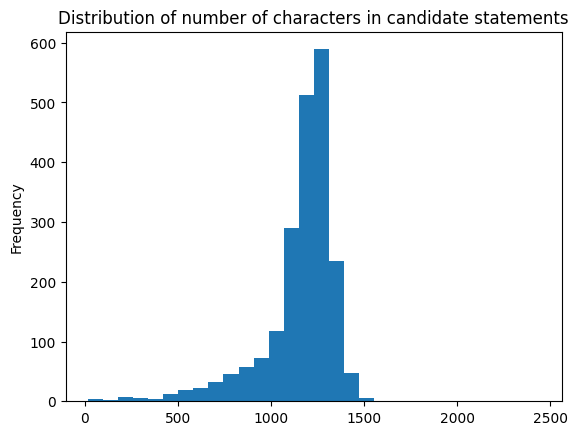

In [53]:
statement_num_char = df_candidate.statement.str.len()

ax = statement_num_char.plot.hist(bins=30)
ax.set_title('Distribution of number of characters in candidate statements');

The shortest statements look legitimate (but not particularly persuasive)

In [54]:
df_candidate[statement_num_char < 75]

,name,questions,photo,statement,contact_name,has_phone,has_email,email_domain,council,ward,vacancies
1721,"MENADUE, Alan",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,www.alanmenadue.com,Alan Maxwell Menadue,True,True,gmail.com,Stonnington City Council,Greville Ward,1
2135,"TALBETT, James",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,My policies include having a beer and watching...,James Talbett,True,False,None,Yarra Ranges Shire Council,O'Shannassy Ward,1


If we consider a word to be a space separated string, most of the candidate statements average 6 characters per word, except for one outlier:

6.26055256228232

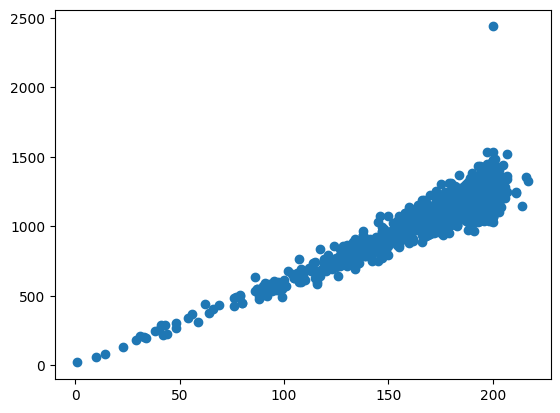

In [55]:
statement_num_word = df_candidate.statement.fillna('').str.split().map(len)

plt.scatter(statement_num_word, statement_num_char)

(statement_num_char / statement_num_word).dropna().mean()

That outlier appears to have a lot of links (I hope they didn't get printed in the candidate leaflet):

In [56]:
df_candidate[df_candidate.statement.str.len() > 2000].iloc[0].statement

'We need a competent, trustworthy Council that is not a variant of the old Council. November 2017: Independent Broad-based Anti-corruption Commission (IBAC), “Operation Sandon Public examinations into allegations of corruption in local government planning and property development decisions”. Tuesday 11th February 2020: City of Casey Municipal Monitor Report, Page 9 Findings, included: “In response to the intense scrutiny by IBAC and the appointment of a municipal monitor, the Councillors have prioritised protecting their reputations rather than that of the City of Casey.”, Page 10 Recommendations, included: “I therefore recommend that: 1. The Casey City Council is dismissed and administrators are appointed.”. Friday 14th February 2020: The Age newspaper, “Casey councillors desert ship as investigator recommends their sacking”. Tuesday 18th February 2020: Parliamentary Debates (Hansard), Page 295, “Her report is damning. It is damning as to the conduct of all councillors ....”; Berwick 

## Ward level statistics

We can also sanity check the ward level statistics

In [57]:
ward_stats = df_candidate.groupby(['council', 'ward']).agg(vacancies = ('vacancies', 'max'), candidates=('name', 'count'))
ward_stats

vacancies  candidates
council                    ward                                            
Alpine Shire Council       Alpine Shire Council               7          12
Ararat Rural City Council  Ararat Rural City Council          7          12
Ballarat City Council      Alfredton Ward                     1           6
                           Brown Hill Ward                    1           3
                           Buninyong Ward                     1           3
...                                                         ...         ...
Yarra Ranges Shire Council Streeton Ward                      1           2
                           Walling Ward                       1           2
Yarriambiack Shire Council Dunmunkle Ward                     2           2
                           Hopetoun Ward                      2           2
                           Warracknabeal Ward                 2           2

[464 rows x 2 columns]

Because of the Local Government Act 2020 the metropolitan wards, which are the majority, have only 1 vacancy.

In [58]:
ward_stats['vacancies'].value_counts()

1    411
3     21
7     13
2     12
5      4
9      3
Name: vacancies, dtype: int64

Most wards have 2 or 3 candidates, with a long tail.

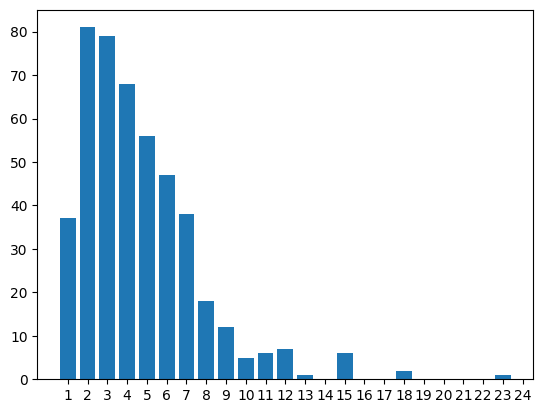

In [59]:
ax = plt.bar(*zip(*Counter(ward_stats['candidates']).items()))
plt.xticks(range(1, 25, 1));

Some waards are uncontested, with as many vacancies as candidates, and others are very hotly contested, for examply Dendy Ward in Bayside Council has 18 candidates for its 1 seat.

In [60]:
ward_stats['candidates_per_vacancy'] = ward_stats['candidates'] / ward_stats['vacancies']
ward_stats.sort_values('candidates_per_vacancy')

vacancies  candidates  \
council                    ward                                           
Loddon Shire Council       Wedderburn Ward                1           1   
Latrobe City Council       Newborough Ward                1           1   
Horsham Rural City Council Wyn Wyn Ward                   1           1   
                           Kalimna Ward                   1           1   
Hindmarsh Shire Council    West Ward                      2           2   
...                                                     ...         ...   
Wyndham City Council       Williams Landing Ward          1          12   
                           Wimba Ward                     1          12   
                           Bemin Ward                     1          15   
Bayside City Council       Castlefield Ward               1          15   
                           Dendy Ward                     1          18   

                                                  candidates_per_vacancy  
council                    ward                                           
Loddon Shire Council       Wedderburn Ward                           1.0  
Latrobe City Council       Newborough Ward                           1.0  
Horsham Rural City Council Wyn Wyn Ward                              1.0  
                           Kalimna Ward                              1.0  
Hindmarsh Shire Council    West Ward                                 1.0  
...                                                                  ...  
Wyndham City Council       Williams Landing Ward                    12.0  
                           Wimba Ward                               12.0  
                           Bemin Ward                               15.0  
Bayside City Council       Castlefield Ward                         15.0  
                           Dendy Ward                               18.0  

[464 rows x 3 columns]

In fact there are a large number of uncontested wards:

In [61]:
uncontested_wards = ward_stats[ward_stats['candidates'] <= ward_stats['vacancies']]
uncontested_wards

vacancies  candidates  \
council                          ward                                           
Banyule City Council             Beale Ward                     1           1   
Buloke Shire Council             Mallee Ward                    2           2   
Cardinia Shire Council           Pakenham Hills Ward            1           1   
Central Goldfields Shire Council Maryborough West Ward          1           1   
                                 Tullaroop Ward                 1           1   
Corangamite Shire Council        Cooriemungle Ward              1           1   
                                 Gnotuk Ward                    1           1   
                                 Lake Elingamite Ward           1           1   
                                 Lake Keilambete Ward           1           1   
                                 Leura Ward                     1           1   
                                 Mt Elephant Ward               1           1   
Greater Bendigo City Council     Epsom Ward                     1           1   
Greater Dandenong City Council   Noble Park Ward                1           1   
Greater Shepparton City Council  Midland Ward                   1           1   
                                 Poplar Ward                    1           1   
Hindmarsh Shire Council          West Ward                      2           2   
Horsham Rural City Council       Kalimna Ward                   1           1   
                                 Wyn Wyn Ward                   1           1   
Latrobe City Council             Newborough Ward                1           1   
Loddon Shire Council             Boort Ward                     1           1   
                                 Terrick Ward                   1           1   
                                 Wedderburn Ward                1           1   
Manningham City Council          Tullamore Ward                 1           1   
                                 Yarra Ward                     1           1   
Mildura Rural City Council       Karadoc Ward                   1           1   
                                 Sunset Country Ward            1           1   
Monash City Council              Gallaghers Ward                1           1   
Mount Alexander Shire Council    Barkers Creek Ward             1           1   
                                 Forest Creek Ward              1           1   
                                 Loddon River Ward              1           1   
                                 Moonlight Creek Ward           1           1   
                                 Tarrengower Ward               1           1   
Wangaratta Rural City Council    King River Ward                1           1   
                                 Warby Ward                     1           1   
Warrnambool City Council         Botanic Ward                   1           1   
                                 Russells Creek Ward            1           1   
                                 Wollaston Ward                 1           1   
Yarra Ranges Shire Council       Chirnside Ward                 1           1   
                                 Ryrie Ward                     1           1   
Yarriambiack Shire Council       Dunmunkle Ward                 2           2   
                                 Hopetoun Ward                  2           2   
                                 Warracknabeal Ward             2           2   

                                                        candidates_per_vacancy  
council                          ward                                           
Banyule City Council             Beale Ward                                1.0  
Buloke Shire Council             Mallee Ward                               1.0  
Cardinia Shire Council           Pakenham Hills Ward                       1.0  
Central Goldfields Shire Council Maryborough West Ward                     1.0  
     

There are a total of 42 wards, with 47 positions, that are uncontested.

In [62]:
len(uncontested_wards), uncontested_wards['vacancies'].sum()

(42, 47)

# Extracting Candidate Questionnaires

There's additional information about candidates in the questionnaires they submitted, and for uncontested elections this is the only information we have.
We have to download them all from external PDFs.

We will save them all to a separate folder:

In [63]:
question_dir = data_dir / 'questionnaires'
question_dir.mkdir(exist_ok=True)

Because there's a lot of files to download as well as being slow to prevent server overload (downloading at most 1 document every 2 seconds), we'll retry with exponential backoff using [tenacity](https://tenacity.readthedocs.io/en/latest/) if the process fails.

In [64]:
@retry(wait=wait_exponential(multiplier=1, min=4, max=60), stop=stop_after_attempt(7))
def download(url, path):
    if path.exists():
        return

    urlretrieve(url, path)
    sleep(2)

Then we can download all the candidate's questionnaires (this took me a couple of hours)

In [65]:
for c in candidates:

    url = c.questions
    if not url:
        continue
    path = question_dir / url.split('/')[-1]

    download(url, path)

While we're downloading assets we can also grab all of their photographs as well:

In [66]:
photo_dir = data_dir / 'photos'
photo_dir.mkdir(exist_ok = True)

for c in candidates:

    url = c.photo
    if not url:
        continue
    path = photo_dir / url.split('/')[-1]

    download(url, path)

## Parse Questionnaire PDFs

For some reason VEC decided the best way to publish the candidate questionnaire responses was in separate PDFs.
Luckily the formatting is consistent enough and informative enough that we can actually extract it.
We have questions for most of the candidates:

In [67]:
questions = sorted(question_dir.glob('*.pdf'))
len(questions)

2098

While [PDF is an open standard](https://en.wikipedia.org/wiki/PDF) it's pretty gnarly to extract things out of, and I'm not sure what the best general libraries for parsing them are.
In this case [PyPDF2](https://pypdf2.readthedocs.io/en/3.x/) is good enough to read the data because it's very consistent, but our approach would break with any small variation.

All of the questionnaires consist of a single page and we can read through that single page.
PyPDF2 uses a visitor pattern and we can use that to run conditional extraction depending on the text, the user matrix cm, the translation matrix tm, the font dictionary and the font size.
The matrices are a rotation matrix followed by a translation matrix, so positions 4 and 5 should correspond to the x and y offset.
I originally printed all the attributes to find out which ones might be meaningful, which is too messy to show here, and discovered that all the text of the candidate responses occurs twice, once with a missing fontDict.
Moreover the `cm[5]` variable is different for most of the text fields (and consistent between PDFs) so we can use that to extract the relevant field.

In [68]:
path = questions[0]
reader = PdfReader(path)
page = reader.pages[0]

def visitor_text_attributes(text, cm, tm, fontDict, fontSize):
    if text.strip() and not fontDict:
        print(dict(text=text, x=cm[4], y=cm[5]))

page.extract_text(visitor_text=visitor_text_attributes);

{'text': 'Frankston City Council 2024', 'x': 242.47, 'y': 708.41}
{'text': 'Derinya Ward', 'x': 242.47, 'y': 688.58}
{'text': 'GRACE, Cassandra', 'x': 242.47, 'y': 669.57}
{'text': 'I believe in a council that listens, values diversity, and acts with transparency. I would like to\nwork collaboratively as a team to make decisions that impact the residents of the City of\nFrankston. I would like to provide respectful, honest and professional leadership of our\ncommunity with community engagement.', 'x': 46.62, 'y': 541.58}
{'text': 'Councillor?', 'x': 445.75, 'y': 515.25}
{'text': 'I have been a dedicated community volunteer for over 30 years. I live in the Derinya Ward\nand have done so my entire life. I have a deep and strong understanding of our community. I\nunderstand what it means to be a business owner. I have strong leadership skills.', 'x': 46.62, 'y': 405.45}
{'text': 'Yes', 'x': 423.55, 'y': 370.11}
{'text': 'Yes', 'x': 423.31, 'y': 349.27}
{'text': 'No', 'x': 423.57, 'y': 327

We use these observations to map the y coordinates back to fields.

In [69]:
coords = {
    708.51: "council",
    688.58: "ward",
    669.57: "name",
    541.58: "vision",
    405.45: "expertise",
    370.11: "read_plan",
    349.27: "read_code",
    327.73: "has_party",
    285.94: "party_name",
    261.59: "councillor",
    240.23: "council_attendance",
    99.74: "contact"
}

We can then parse a PDF by extracting the data from fields with the corresponding `cm[5]` coordinate with an empty `fontDict`.
We allow passing in extra kwargs of context that are passed into the output dictionary, so that we can add the file name.

In [70]:
def parse_pdf(path, **kwargs):
    reader = PdfReader(path)
    page = reader.pages[0]

    data = kwargs
    def visitor(text, cm, tm, fontDict, fontSize):
        if text.strip() and not fontDict:
            coord = cm[5]
            if coord in coords:
                value = coords[coord]
                if value in data:
                    raise ValueError(f"Duplicate {value}")
                data[value] = text

    page.extract_text(visitor_text=visitor)

    return data

And apply it to all of the questionnaires:

In [71]:
questionnaires = []

for q in questions:
    questionnaires.append(parse_pdf(q, question_file=q.name))

## Analysing questionaires

Let's do some sense checking of the data in the questionnaires, we'll ignore the contacts because there's not much additional information we don't already have and it may not be appropriate to publish in a dataset.

In [72]:
df_q = pd.DataFrame(questionnaires).drop('contact',axis=1)

df_q

,question_file,ward,name,vision,expertise,read_plan,read_code,has_party,councillor,council_attendance,party_name
0,19672.pdf,Derinya Ward,"GRACE, Cassandra","I believe in a council that listens, values di...",I have been a dedicated community volunteer fo...,Yes,Yes,No,No,NaN,NaN
1,19673.pdf,Tooronga Ward,"BELL, Jamie",A better Stonnington Council prioritises trans...,"As a management consultant, my ability to anal...",Yes,Yes,No,No,NaN,NaN
2,19674.pdf,Dendy Ward,"SCANLON, Terence",Bayside vision for improvement & growth while ...,"Multinational business management skills, impl...",Yes,Yes,No,No,NaN,NaN
3,19675.pdf,Coliban Ward,"LESSER, Max",A connected community,Previous local government employee and innovat...,Yes,Yes,No,No,NaN,NaN
4,19676.pdf,Jeeralang Ward,"DUNCAN, Peter",My vision for Latrobe City is to have a counci...,My expertise and attributes that will assist m...,Yes,Yes,No,No,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2093,21939.pdf,Streeton Ward,"PETERSEN, Sigrid","To work with local council, residents and comm...","I am local mother and business owner, with str...",Yes,Yes,No,No,NaN,NaN
2094,21941.pdf,Walling Ward,"FERRIER, David",I want to lead the way in developing support p...,Over the past 3 years I have led a local commu...,Yes,Yes,No,No,NaN,NaN
2095,21943.pdf,Horsham North Ward,"ROSS, Kathy",I would like to see a community that is engage...,I have understanding of government and legisla...,Yes,Yes,No,No,NaN,NaN
2096,21944.pdf,Banksia Ward,"MATTHEWS, Corey",Answer not submitted,Answer not submitted,Answer not submitted,Answer not submitted,Answer not submitted,Answer not submitted,NaN,NaN


The only columns with missing values are `council_attendance` which only makkes sense if `councillor`, and `party_name` which only makes sense if `has_party`.

In [73]:
df_q.isna().sum()

question_file            0
ward                     0
name                     0
vision                   0
expertise                0
read_plan                0
read_code                0
has_party                0
councillor               0
council_attendance    1687
party_name            1818
dtype: int64

All the files are distinct

In [74]:
df_q['question_file'].duplicated().any()

False

Almost all candidates read the Council Plan for the council they want to be elected to, and read the Councillor Code of conduct, but surprisingly a few candidates didn't.

In [75]:
df_q[['read_plan', 'read_code']].value_counts(dropna=False)

read_plan             read_code           
Yes                   Yes                     2053
No                    Yes                       26
                      No                         9
Yes                   No                         5
Answer not submitted  Answer not submitted       4
                      Yes                        1
dtype: int64

Almost one-fifth of the candidates are currently a Councillor, and most of them have attended more than 90% of council meetings.

In [76]:
df_q[['councillor', 'council_attendance']].value_counts(dropna=False)

councillor            council_attendance
No                    NaN                   1683
Yes                   >90%                   374
                      75 – 90%                37
Answer not submitted  NaN                      4
dtype: int64

Most candidates have not been *endorsed* by a party, and of those who are most are with the Australian Greens or Victorian Socialists.
Note that a lot more candidates are *affiliated* with a party, but not officially endorsed, and do not need to disclose that affiliation.
The [political affiliation of candidates is murky](https://web.archive.org/web/20241003054449/https://www.theage.com.au/national/victoria/many-of-your-local-election-candidates-appear-to-be-independent-our-survey-reveals-otherwise-20240929-p5kedz.html), there are candidates running as [independent Liberals](https://www.localelections.com.au/post/see-the-canva-template-being-used-by-liberal-party-members-at-victoria-s-local-elections) using the Liberal party colours but not endorsed by the Liberal party, and similarly candidates running as [community Labor](https://www.localelections.com.au/post/they-re-called-community-labor-but-these-maribyrnong-candidates-are-not-party-endorsed) who are not officially endorsed by the Labor party.
There are also [other quasi-parties](https://www.tallyroom.com.au/56999) such as Yarra For All in Yarra and the Socialist Alliance.

In [77]:
df_q[['has_party', 'party_name']].value_counts(dropna=False)

has_party             party_name            
No                    NaN                       1814
Yes                   Australian Greens          123
                      Victorian Socialists        77
                      Australian Labor Party      53
                      Libertarian                 14
                      AJP                          9
Answer not submitted  NaN                          4
Yes                   Liberal                      4
dtype: int64

All PDFs have text from the vision and expertise:

The vision for most Victorian Socialsts (top) and Australian Greens (second) candidates is the same, and some candidates did not submit an answer.

In [78]:
Counter(df_q['vision']).most_common(5)

[('Victorian Socialists don’t hide behind the lie that local government is only about roads, rates\nand rubbish. I’ll fight for a local government that will stand up to the state and federal\ngovernment and demand policies that put the public before corporate profits.',
  38),
 ('Council has an important role in ensuring that all of us thrive and that our local environment is\nprotected. Together, we can continue building a supportive, vibrant and diverse community by\ndelivering the infrastructure and services we all need.',
  22),
 ('Answer not submitted', 11),
 ('A vibrant, inclusive community where residents and businesses thrive. A council led by\nindependent residents, not tied to political parties or campaign donors, but representing the\nvoices of Melbourne. Revitalised neighbourhoods, increased green spaces, and improved\nservices. We will ensure council delivers on its core priorities, maximising value for\nratepayers.',
  4),
 ('Focus needs to be on local council mandate and

Even more concerning is a lot of Socialist candidates have the same "expertise", and some people did not submit an answer.

In [79]:
Counter(df_q['expertise']).most_common(3)

[('I’m committed to standing up for the community. First of all that means I want to listen to you.\nI’ll always answer my phone to residents and community groups and campaign to make sure\nyour voice is heard.',
  25),
 ('Answer not submitted', 11),
 ('Local Small Business Experience and having grown up and have always worked within the\ncommunity.',
  2)]

The number of characters looks pretty reasonable for the vision and relevant expertise:

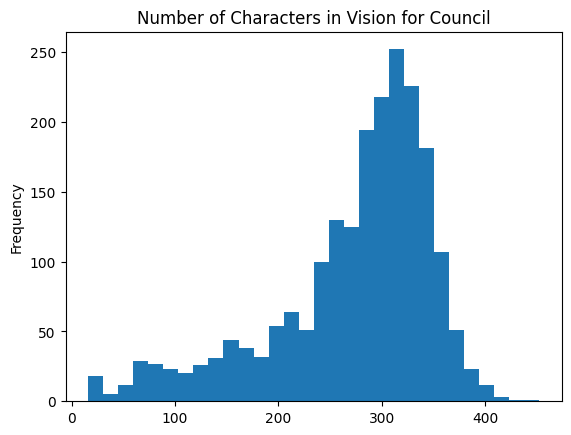

In [80]:
ax = df_q['vision'].str.len().plot.hist(bins=30)
ax.set_title('Number of Characters in Vision for Council');

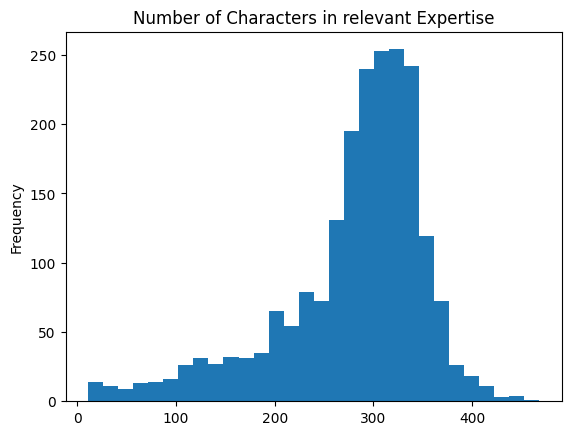

In [81]:
ax = df_q['expertise'].str.len().plot.hist(bins=30)
ax.set_title('Number of Characters in relevant Expertise');

# Putting it all together

Let's merge together the questionnaire with the other candidate data.

In [82]:
df_candidate['question_file'] = df_candidate['questions'].str.replace(".*/", "", regex=True)
df_candidate['photo_file'] = df_candidate['photo'].str.replace(".*/", "", regex=True)

df_full = df_candidate.merge(df_q, how='left', on='question_file', suffixes=('', '_q'))
assert len(df_full) == len(df_candidate)

df_full.head()

,name,questions,photo,statement,contact_name,has_phone,has_email,email_domain,council,ward,vacancies,question_file,photo_file,ward_q,name_q,vision,expertise,read_plan,read_code,has_party,councillor,council_attendance,party_name
0,"ANDERSEN, John",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,"My name is John Andersen, also known as Snowy....",John Andersen,True,True,yahoo.com.au,Alpine Shire Council,Alpine Shire Council,7,20384.pdf,20384.png,Alpine Shire Council,"ANDERSEN, John",Greater community engagement in council decisi...,Hard working ethic and community-based experie...,Yes,Yes,No,No,NaN,NaN
1,"SMITH, Peter",None,https://itsitecoreblobvecprd.blob.core.windows...,My name is Peter Smith. I am a 54 year old res...,Peter Smith,True,True,expressfinanceoptions.com.au,Alpine Shire Council,Alpine Shire Council,7,None,19773.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"RONCO, Jean-Pierre",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,As a candidate at the Alpine Shire Council ele...,Jean-Pierre Louis Ronco,True,True,hotmail.com,Alpine Shire Council,Alpine Shire Council,7,19701.pdf,19701.png,Alpine Shire Council,"RONCO, Jean-Pierre",I would like to see a united community which b...,"I enjoy listening to diverse opinions, I work ...",Yes,Yes,No,No,NaN,NaN
3,"BYRNE, David",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,"My name is David Byrne. Ten years ago, my fami...",David Byrne,True,True,arderns.com.au,Alpine Shire Council,Alpine Shire Council,7,20266.pdf,20266.png,Alpine Shire Council,"BYRNE, David",The Alpine Shire’s unique character is shaped ...,As the owner of Arderns Caravan Park in Myrtle...,Yes,Yes,No,No,NaN,NaN
4,"McDONALD, Bruce",https://itsitecoreblobvecprd.blob.core.windows...,https://itsitecoreblobvecprd.blob.core.windows...,"A resident of Bright with a no-nonsense, down ...",Bruce McDonald,True,True,gmail.com,Alpine Shire Council,Alpine Shire Council,7,20189.pdf,20189.png,Alpine Shire Council,"McDONALD, Bruce",To make and keep Alpine Shire the best place t...,"Common sense, no nonsense ability to solve pro...",Yes,Yes,No,No,NaN,NaN


We'll check that the data from the questionnaire is consistent:

In [83]:
assert (df_full['name_q'].isna() | (df_full['name'] == df_full['name_q'])).all()
assert (df_full['ward_q'].isna() | (df_full['ward'] == df_full['ward_q'])).all()

Let's tidy up the columns and column names for export

In [84]:
df = (
    df_full.copy()
    [['council', 'ward', 'vacancies', 'name',
      'statement', 'vision', 'expertise',
      'read_plan', 'read_code', 'has_party',
      'party_name', 'councillor', 'council_attendance',
      'has_phone', 'has_email', 'email_domain', 'contact_name',
      'photo_file']]
)

df.loc[df['councillor'] == 'No', 'council_attendance'] = 'N/A'
df.loc[df['has_party'] == 'No', 'party_name'] = 'N/A'
df.loc[~df['has_email'], 'email_domain'] = 'N/A'
df = df.fillna('Answer not submitted')

df['has_phone'] = np.where(df['has_phone'], 'Yes', 'No')
df['has_email'] = np.where(df['has_email'], 'Yes', 'No')

df = df.rename(columns = dict(
    vacancies = "ward_vacancies",
))

df.to_csv('2024_victorian_council_candidates.csv', index=False)

# What next

There are various ways to further enrich the data for more specific analyses.
For example with the [geometric boundaries](https://discover.data.vic.gov.au/dataset/vicmap-admin) the councils and wards could be mapped to ABS Statistical Areas, and linked to Census and other demographic data.
They could also be linked to state or national electoral boundaries (which would be much larger) and linked to votes for major political parties.
More could be done to find council candidates specific political affiliations, for example [Councilwatch ran a survey](https://www.councilwatch.com.au/vicanswers) that includes political party affiliation.
We could also run a separate extract for Melbourne City Council, for which there's a richer structure and more information available.

However I think the dataset as is should be rich enoguh to do interesting analyses.
I have a hypothesis that the topics candidates focus on within a council are much narrower than the topics between councils; this could give an indication of the topics that are of interest within a specific area.
It could be interesting to get a list of topics and see which candidates mention them, and their positions, and how this varies across councils.
Hopefully you find this a useful resource for understanding Victoria and its people.